# Memory check

In [13]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models

import json

import time

from PIL import Image

import numpy as np

from collections import OrderedDict

Get the device. Device is either cuda:0 or cpu

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [15]:
data_dir = '/home/horst/ml/udacity/udacity-dl-pytorch/Cat_Dog_data/Cat_Dog_data/'
train_dir = data_dir + '/train'
#valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [16]:
# Define the transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224), 
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

#valid_transforms = transforms.Compose([transforms.Resize(256), 
#                                       transforms.CenterCrop(224), 
#                                       transforms.ToTensor(), 
#                                       transforms.Normalize([0.485, 0.456, 0.406],
#                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256), 
                                       transforms.CenterCrop(224), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform = train_transforms)
#valid_datasets = datasets.ImageFolder(valid_dir, transform = valid_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_datasets, batch_size = 64, shuffle=True)
#validloader = torch.utils.data.DataLoader(valid_datasets, batch_size=3)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=32)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [17]:
# Build and train the network
model_name = 'densenet121'
#model_name = 'vgg19'
#model_name = 'vgg13'
if model_name == 'densenet121':
    model = models.densenet121(pretrained=True)
elif model_name == 'vgg19':
    model = models.vgg19(pretrained=True)
elif model_name == 'vgg13':
    model = models.vgg13(pretrained=True)
else:
    print('You did not choose a model! Please choose a model to continue')
    model = None
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [18]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
if model_name == 'densenet121':
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(1024, 500)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(500, 2)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
elif model_name == 'vgg19': 
    classifier = nn.Sequential(OrderedDict([
        ('fcl1', nn.Linear(25088, 500)), 
        ('relo', nn.ReLU()), 
        ('fcl2', nn.Linear(500, 2)), 
        ('output', nn.LogSoftmax(dim=1))
    ]))
    
model.classifier = classifier

In [19]:
# Train a model with a pre-trained network

criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


model.to(device)

epochs = 1
steps = 0
running_loss = 0
print_every = 100

start = time.time()

for e in range(epochs):
    model.train()
    for images, labels in iter(trainloader):
        steps += 1
        
        # Wrap images and labels in Variables so we can calculate gradients
        inputs = Variable(images)
        labels = Variable(labels)
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model.forward(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Model in inference mode, dropout is off
            model.eval()
        
            accuracy = 0
            valid_loss = 0
            for ii, (images, labels) in enumerate(testloader):
                
                # don't save the history
                with torch.no_grad():
                    inputs = Variable(images)
                    labels = Variable(labels)
                
                inputs, labels = inputs.to(device), labels.to(device)

                output = model.forward(inputs)
                valid_loss += criterion(output, labels).item()
                
                ## Calculating the accuracy 
                # Model's output is log-softmax, take exponential to get the probabilities
                ps = torch.exp(output).data
                # Class with highest probability is our predicted class, compare with true label
                equality = (labels.data == ps.max(1)[1])
                # Accuracy is number of correct predictions divided by all predictions, just take the mean
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Validation Loss: {:.3f}.. ".format(valid_loss/len(testloader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure dropout is on for training
            model.train()

torch.cuda.empty_cache()
            
print("Time for training and validation : {:.0f} minutes and {:.3f} seconds".format((time.time() - start)/60, (time.time() - start) % 60))

Epoch: 1/1..  Training Loss: 0.205..  Validation Loss: 0.045..  Validation Accuracy: 0.983
Epoch: 1/1..  Training Loss: 0.156..  Validation Loss: 0.062..  Validation Accuracy: 0.977
Epoch: 1/1..  Training Loss: 0.160..  Validation Loss: 0.049..  Validation Accuracy: 0.981
Time for training and validation : 3 minutes and 30.706 seconds


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [20]:
# validate on the test set
model.eval()

accuracy = 0
test_loss = 0
for ii, (images, labels) in enumerate(testloader):

    # don't save the history
    with torch.no_grad():
        inputs = Variable(images)
        labels = Variable(labels)

    inputs, labels = inputs.to(device), labels.to(device)

    output = model.forward(inputs)
    
    #test_loss += criterion(output, labels).item()

    ## Calculating the accuracy 
    # Model's output is log-softmax, take exponential to get the probabilities
    ps = torch.exp(output).data
    # Class with highest probability is our predicted class, compare with true label
    equality = (labels.data == ps.max(1)[1])
    # Accuracy is number of correct predictions divided by all predictions, just take the mean
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    
torch.cuda.empty_cache()

print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Test Accuracy: 0.987


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [21]:
checkpoint = {'arch': model_name,
              'classifier': classifier,
              'criterion': criterion,
              'optimizer': optimizer,
              'optimizer_dict': optimizer.state_dict(), 
              'state_dict': model.state_dict(),
              'epochs': epochs}
              #'class_to_idx': model.class_to_idx}

torch.save(checkpoint, 'memory_checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [22]:
# load the checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    # get the model / architecture name
    model_name = checkpoint['arch'] 
    # int a new model
    if model_name == 'densenet121':
        model_a = models.densenet121(pretrained=True)
    elif model_name == 'vgg19':
        model_a = models.vgg19(pretrained=True)
    elif model_name == 'vgg13':
        model_a = models.vgg19(pretrained=True)
    else:
        print('No correct model transmitted')
        model_a = None
    # set the device to the model   
    model_a.to(device)
    # assign the classifier of the stored model to the new one
    model_a.classifier = checkpoint['classifier']
    # assign the criterion of the stored model to the new one
    model_a.criterion = checkpoint['criterion']
    # get the model.state_dict() of the stored model
    model_a.load_state_dict(checkpoint['state_dict'])
    # get the weights of the stored model
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_dict'])
    # get the epochs of the stored (and trained) model
    epochs = checkpoint['epochs']
    # get the class to index of the stored model
    #model_a.class_to_idx = checkpoint['class_to_idx']
    
    return model_a

In [23]:
new_model = load_checkpoint('memory_checkpoint.pth')
print(new_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [24]:
# check if the restored new_model is working
new_model.eval()

accuracy = 0
test_loss = 0
for ii, (images, labels) in enumerate(testloader):

    # don't save the history
    with torch.no_grad():
        inputs = Variable(images)
        labels = Variable(labels)
        
        inputs, labels = inputs.to(device), labels.to(device)

        output = new_model.forward(inputs)

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output).data
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()
    
torch.cuda.empty_cache()

print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Test Accuracy: 0.987


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [16]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # set the mean and standard deviation
    mean = [0.485, 0.456, 0.406] 
    stdv = [0.229, 0.224, 0.225] 
    
    # import / open the image
    test_image = Image.open(image)
    # rezide the image to 256 x 256
    img = test_image.resize((256,256))
    # crop the image from the center position with size 224
    center_point = img.size[0] / 2
    img = img.crop((center_point-112, center_point-112, center_point + 112, center_point + 112))

    #convert the PIL image into a np array
    np_image = np.array(img)
    #convert color channel values (0 to 255) to floats in range of 0 to 1
    img = np_image / 255
    #normalize the image
    img = (img-mean) / stdv

    # reoder dimensions
    img = img.transpose((2,0,1))
    # convert np array to tensor
    img = torch.from_numpy(img)

    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

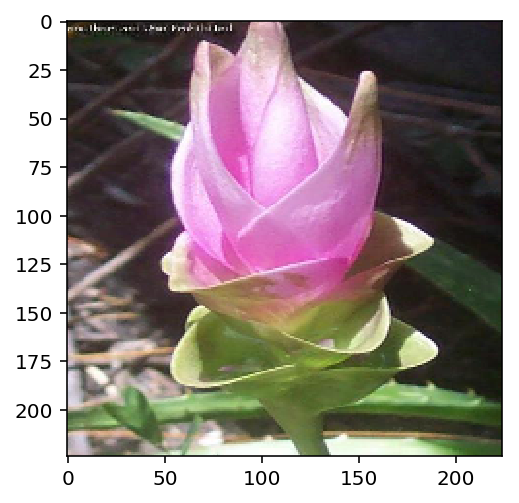

In [18]:
imshow(process_image(test_dir + '/39/image_07016.jpg'));

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [19]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # code to predict the class from an image file
    model_new = load_checkpoint(model)
    
    model_new.eval()

    img = process_image(image_path)
    img = img.float()
    img.unsqueeze_(0)
    img = img.to(device)
    with torch.no_grad():
        output = model_new.forward(img)

    ps = torch.exp(output)
    
    probs = torch.topk(ps,5)[0]
    probs = probs.cpu()
    probs = probs.numpy()
    probs = probs[0]

    
    cla = []
    classes = torch.topk(ps,5)[1]
    classes = classes.cpu()
    classes = classes.numpy()
    classes = classes[0]

    for l in range(len(classes)):
        cla.append(model_new.class_to_idx[classes[l]])

    
    return probs, cla

In [20]:
# image_path = test_dir + '/1/image_06743.jpg' # on position 1 -> correct classified
# image_path = test_dir + '/2/image_05107.jpg'  # on position 1 -> correct classified
# image_path = test_dir + '/23/image_03409.jpg'  # on position 1 -> correct classified
# image_path = test_dir + '/39/image_07016.jpg' # on position 1 -> correct classified
# image_path = test_dir + '/43/image_02365.jpg'  # on position 1 -> correct classified
# image_path = test_dir + '/85/image_04808.jpg'  # not listed -> false classified
# image_path = test_dir + '/85/image_04786.jpg'  # # on position 2 -> false classified
image_path = test_dir + '/94/image_07357.jpg' # on position 1 -> correct classified



model_checkpoint = 'checkpoint.pth'
probs, classes = predict(image_path, model_checkpoint)

print(probs)
print(classes)


[0.9324427  0.00955562 0.00800773 0.00721975 0.00672699]
['94', '38', '79', '55', '72']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

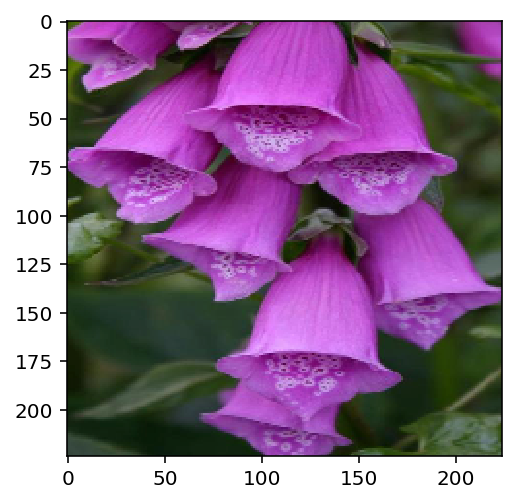

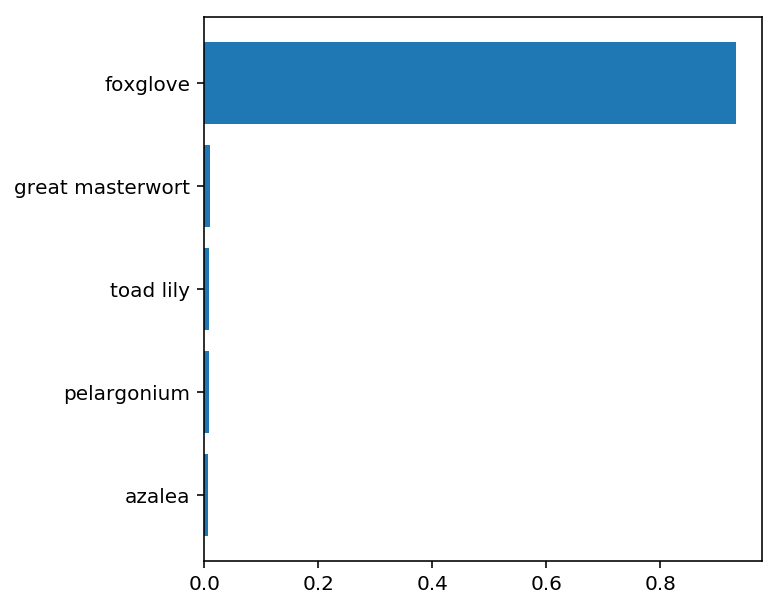

In [21]:
# TODO: Display an image along with the top 5 classes

#convert from the class integer encoding to actual flower names
classes_names = []
classes_names_rev = []
for l in range(len(classes)):
    classes_names.append(cat_to_name[classes[l]])
    
# revert the classes names for platting
classes_names_rev = classes_names[::-1]
    
# revert the probs array for plotting
probs_rev = probs[::-1]

# print(cat_to_name)
# print('orig class order: ', classes_names)
# print('reve class order: ', classes_names_rev)
# print('orig array order: ', probs)
# print('reve array order: ', probs_rev)

# plot the image
imshow(process_image(image_path))


# plot the bar chart
plt.figure(figsize = [5, 5])
y_pos = np.arange(len(classes_names_rev))
plt.barh(y_pos, probs_rev, align='center')
plt.yticks(y_pos, classes_names_rev)
 
plt.show()